In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import warnings

import doralite
import gfdl_utils.core as gu
import CM4Xutils
import numpy as np
import xarray as xr
import xgcm

import gsw, xwmt, xhistogram
import zarr

In [7]:
import cmocean
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple
plt.rcParams.update({'font.size': 12})

In [8]:
from common import *
grids = load_datasets()
grid = grids['CM4Xp125_forced']

In [9]:
wm = xwmt.WaterMass(grid)
wm.get_density("sigma2");
grid = wm.grid # reassign grid since we have modified a copy within wm
ds = grid._ds # reassign ds since we have modified a copy within grid
ds["z"] = ds.z.transpose("year", "zl", "yh", "xh")

In [10]:
tracer = "cfc11"

In [11]:
tracer_content = ds.cfc11.fillna(0.)*ds.thkcello.fillna(0.)
tracer_binned = grid.transform(
    tracer_content,
    "Z",
    sigma2_i,
    target_data=ds.sigma2,
    method="conservative"
).rename({"sigma2": "sigma2_l"})
tracer_layer_inventory = (tracer_binned*ds.areacello).sum(["xh", "yh"]).compute()*g_per_mol[tracer]*1e-9 # Gg

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:464: UserWarning: The `target data` input is not located on the cell bounds. This method will continue with linear interpolation with repeated boundary values. For most accurate results provide values on cell bounds.
  warnings.warn(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


In [12]:
tracer_layer_fluxes = xhistogram.xarray.histogram(
    ds.sigma2_surface.rename("sigma2"),
    bins=sigma2_i,
    dim=("xh", "yh",),
    weights=ds.areacello*ds[f"fg{tracer}"],
    bin_dim_suffix="_l",
).compute().groupby("time.year").mean("time")
tracer_atm_flux_into_layer = (tracer_layer_fluxes * g_per_mol[tracer] * sec_per_year * Gg_per_g).cumsum("year")

# Shift cumulative atm flux so it lines up better with annual-mean concentrations
tracer_atm_flux_into_layer = xr.concat([
    tracer_atm_flux_into_layer.isel(year=[0]),
    0.5*(
        tracer_atm_flux_into_layer.isel(year=slice(1,None)) +
        tracer_atm_flux_into_layer.isel(year=slice(0,ds.year.size-1)).values
    ),
], dim="year")

tracer_diapycnal_flux = tracer_layer_inventory - tracer_atm_flux_into_layer

/vftmp/Henri.Drake/pid10200/ipykernel_5971/1390199050.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(
/vftmp/Henri.Drake/pid10200/ipykernel_5971/1390199050.py:30: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(
/vftmp/Henri.Drake/pid10200/ipykernel_5971/1390199050.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = ax.pcolormesh(
/vftmp/Henri.Drake

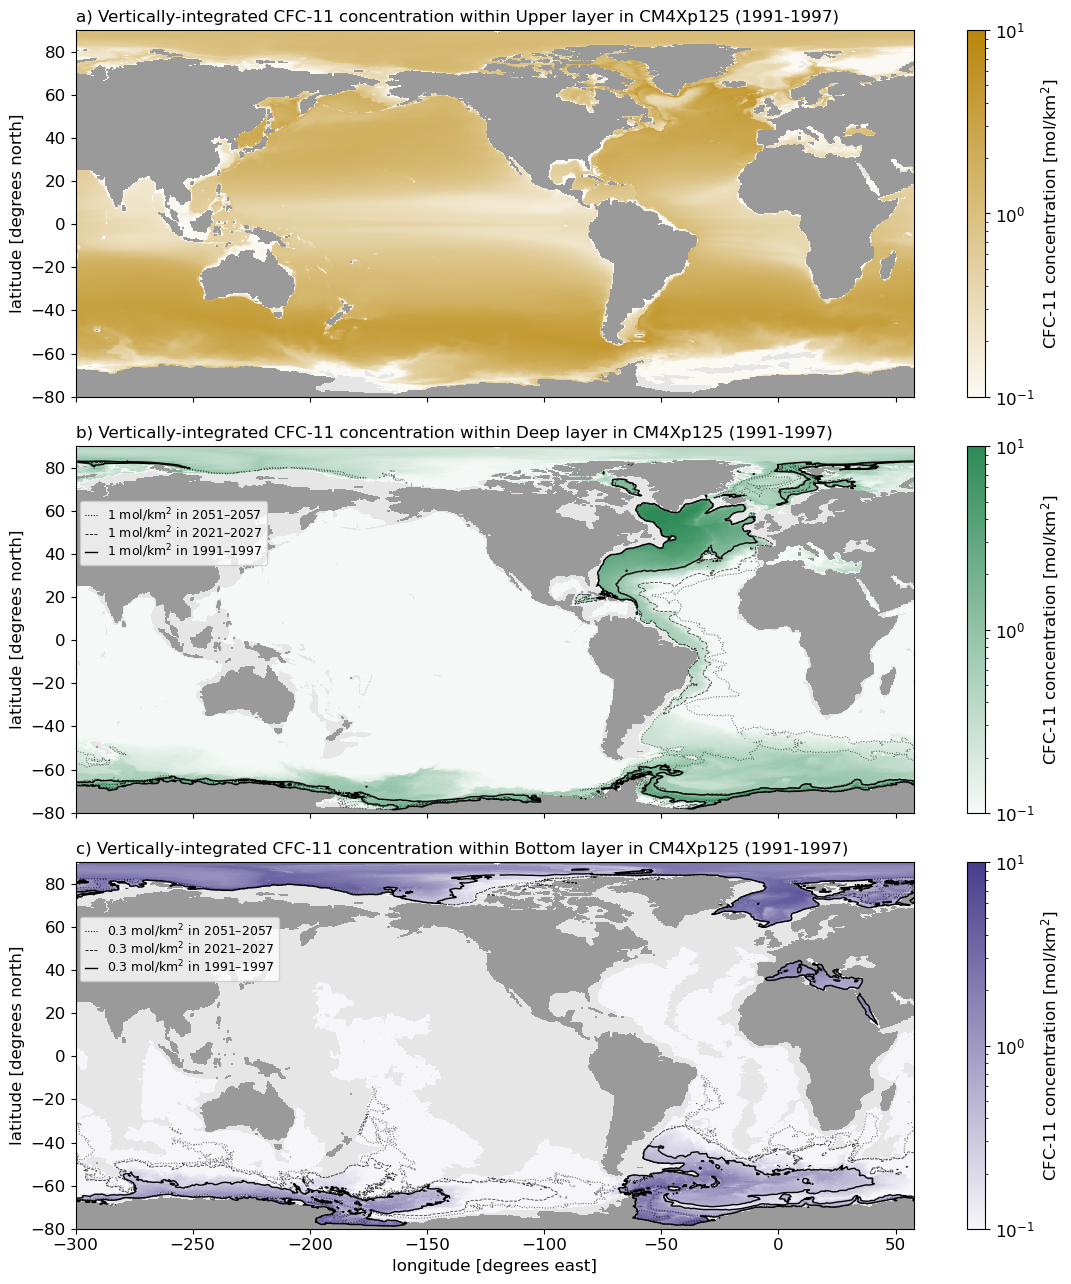

In [13]:
layer_tracer_maps = tracer_binned.sel(year=slice(1991, 1997)).mean("year").compute()

years = [1994+60, 1994+30, 1994]
linestyles = [":", "--", "-"]
linewidths = [0.75, 0.6, 1.]
alphas = [0.6, 0.75, 1.]
levels = [None, 1, 0.3]

fig, axes = plt.subplots(3,1,figsize=(11.5, 13))
for k, (ax, level) in enumerate(zip(axes, levels)):
    pc = ax.pcolormesh(
        layer_tracer_maps.geolon,
        layer_tracer_maps.geolat,
        (layer_tracer_maps*m2_per_km2).isel(sigma2_l=k),
        norm=colors.LogNorm(vmin=1e-1, vmax=10),
        cmap=cmap_offwhite_fade(layer_colors[k])
    )
    if k>0:
        for year, linestyle, linewidth, alpha in zip(years, linestyles, linewidths, alphas):
            ax.contour(
                layer_tracer_maps.geolon,
                layer_tracer_maps.geolat,
                tracer_binned.sel(year=slice(year-3, year+3)).mean("year").isel(sigma2_l=k)*m2_per_km2,
                levels=[level], colors="k", linestyles=linestyle, linewidths=linewidth, alpha=alpha,
            )
            ax.plot(
                [], [], color="k", linestyle=linestyle, linewidth=linewidth,
                label=rf"{level} mol/km${{^2}}$ in {year-3}–{year+3}"
            )
    ax.pcolor(
        grid._ds.geolon,
        grid._ds.geolat,
        grid._ds.deptho.fillna(0.).where(grid._ds.deptho.fillna(0.)==0.) + 1,
        cmap=cmocean.cm.gray,
        vmin=0, vmax=1.5
    )
    
    plt.colorbar(pc, ax=ax, label=r"CFC-11 concentration [mol/km$^{2}$]")

titles = [
    "a) Vertically-integrated CFC-11 concentration within Upper layer in CM4Xp125 (1991-1997)",
    "b) Vertically-integrated CFC-11 concentration within Deep layer in CM4Xp125 (1991-1997)",
    "c) Vertically-integrated CFC-11 concentration within Bottom layer in CM4Xp125 (1991-1997)",
    ]
for p, (ax, title) in enumerate(zip(axes, titles)):
    ax.set_ylim(-80, 90)
    ax.set_xlim(-300, 58)
    ax.set_title(title, loc="left", fontsize=12)
    if p==2:
        ax.set_xlabel("longitude [degrees east]")
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    if p>0:
        ax.legend(handlelength=1, labelspacing=0.06, fontsize=9, loc=(0.005, 0.675))
    ax.set_ylabel("latitude [degrees north]")

fig.tight_layout()
plt.savefig(f"../figures/Fig4_oceanic_{tracer}_layer_map.png", dpi=400, bbox_inches="tight")

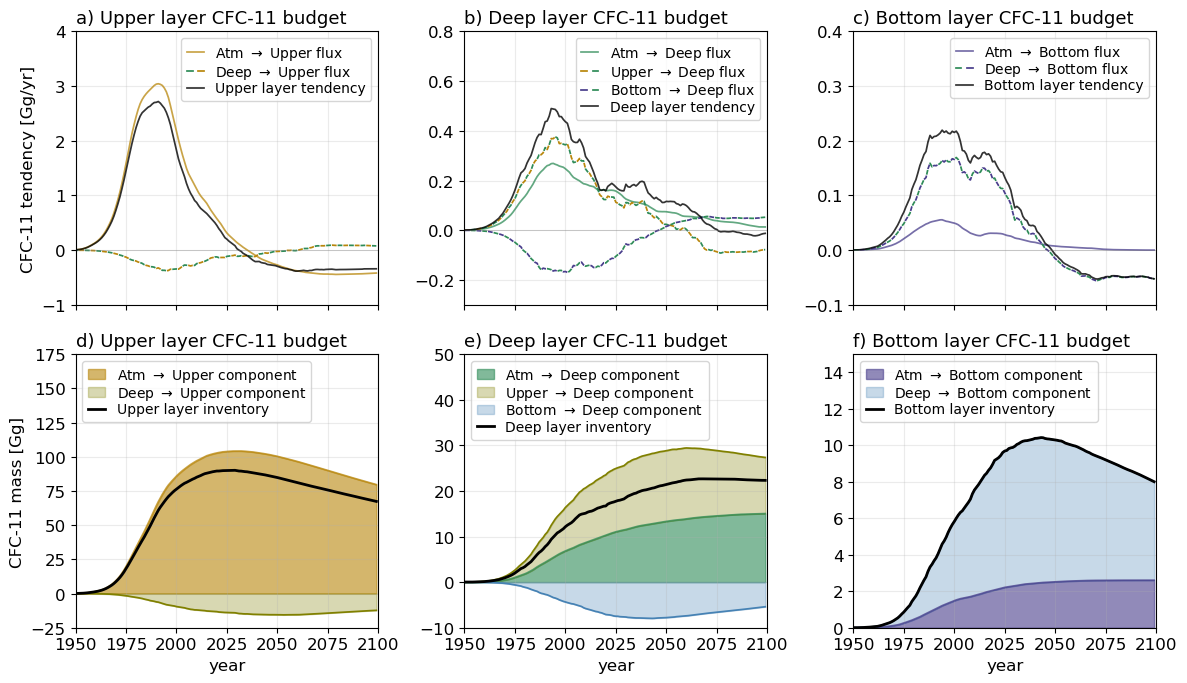

In [14]:
from common import *

fig, axes = plt.subplots(2,3,figsize=(12, 7))
linelength = 2.75
gaplength = linelength*0.2
linestyles = [
    (0, (linelength, (linelength + gaplength*2))),
    (linelength+gaplength, (linelength, (linelength + gaplength*2)))
]
rollperiod = 10

## UPPER ROW: BUDGET
handles, labels = [[], [], []], [[], [], []]

for k, label, color in zip([0,1,2], layer_labels_short, layer_colors):
    ax = axes[0][k]
    l = tracer_atm_flux_into_layer.isel(sigma2_l=k).diff("year").rolling({"year":rollperiod}, min_periods=1).mean("year").plot(
        ax=ax, color=color, lw=1.25, alpha=0.75, label=rf"Atm $\rightarrow$ {label} flux"
    )
    handles[k].append(l[0])
    labels[k].append(l[0].get_label())

# Upper layer budget
k = 0
ax = axes[0][k]
ls = ()
for color, linestyle in zip([layer_colors[k], layer_colors[k+1]], linestyles):
    l = (tracer_diapycnal_flux.isel(sigma2_l=k)).diff("year").rolling({"year":rollperiod}, min_periods=1).mean("year").plot(
        ax=ax, color=color, linestyle=linestyle, lw=1.25,
        label=rf"{layer_labels_short[k+1]} $\rightarrow$ {layer_labels_short[k]} flux"
    )
    l_manual = ax.plot([], [], color=color, linestyle="-", lw=1.25)
    ls += (l_manual[0],)
handles[k].append(tuple(reversed(ls)))
labels[k].append(l[0].get_label())

# Deep layer budget
k = 1
ax = axes[0][k]
ls = ()
for color, linestyle in zip([layer_colors[k], layer_colors[k-1]], linestyles):
    l = (-tracer_diapycnal_flux.isel(sigma2_l=k-1)).diff("year").rolling({"year":rollperiod}, min_periods=1).mean("year").plot(
        ax=ax, color=color, linestyle=linestyle, lw=1.25,
        label=rf"{layer_labels_short[k-1]} $\rightarrow$ {layer_labels_short[k]} flux"
    )
    l_manual = ax.plot([], [], color=color, linestyle="-", lw=1.25)
    ls += (l_manual[0],)
handles[k].append(tuple(reversed(ls)))
labels[k].append(l[0].get_label())

ls = ()
for color, linestyle in zip([layer_colors[k], layer_colors[k+1]], linestyles):
    l = (-tracer_diapycnal_flux.isel(sigma2_l=k+1)).diff("year").rolling({"year":rollperiod}, min_periods=1).mean("year").plot(
        ax=ax, color=color, linestyle=linestyle, lw=1.25,
        label=rf"{layer_labels_short[k+1]} $\rightarrow$ {layer_labels_short[k]} flux"
    )
    l_manual = ax.plot([], [], color=color, linestyle="-", lw=1.25)
    ls += (l_manual[0],)
handles[k].append(tuple(reversed(ls)))
labels[k].append(l[0].get_label())

# Bottom layer budget
k = 2
ax = axes[0][k]
ls = ()
for color, linestyle in zip([layer_colors[k], layer_colors[k-1]], linestyles):
    l = (tracer_diapycnal_flux.isel(sigma2_l=k)).diff("year").rolling({"year":rollperiod}, min_periods=1).mean("year").plot(
        ax=ax, color=color, linestyle=linestyle, lw=1.25,
        label=rf"{layer_labels_short[k-1]} $\rightarrow$ {layer_labels_short[k]} flux"
    )
    l_manual = ax.plot([], [], color=color, linestyle="-", lw=1.25)
    ls += (l_manual[0],)
handles[k].append(tuple(reversed(ls)))
labels[k].append(l[0].get_label())

for k, label, color, panel in zip([0,1,2], layer_labels, layer_colors, ["a", "b", "c"]):
    ax = axes[0][k]
    l = tracer_layer_inventory.isel(sigma2_l=k).diff("year").rolling({"year":rollperiod}, min_periods=1).mean("year").plot(
        ax=ax, color="k", lw=1.25, label=f"{label} tendency", alpha=0.8
    )
    handles[k].append(l[0])
    labels[k].append(l[0].get_label())
    
    ax.set_xlim(1950, 2100)
    ax.legend(
        handles=handles[k],
        labels=labels[k],
        handler_map={tuple: HandlerTuple(ndivide=None)}, numpoints=1,
        labelspacing=0.06, handlelength=1.25, loc="upper right", fontsize=10
    )
    ax.set_title("")
    ax.set_title(f"{panel}) {label} CFC-11 budget", fontsize=13, loc="left")
    if k==0:
        ax.set_ylabel("CFC-11 tendency [Gg/yr]")
    else:
        ax.set_ylabel("")
    ax.grid(True, alpha=0.25)
    ax.set_xlabel("")
    ax.set_xticklabels("")
    ax.axhline(0., alpha=0.5, color="grey", lw=0.5)

axes[0][0].set_ylim(-1, 4)
axes[0][1].set_ylim(-0.3, 0.8)
axes[0][2].set_ylim(-0.1, 0.4)

## LOWER ROW: INVENTORY
for k, label, color in zip([0,1,2], layer_labels_short, layer_colors):
    ax = axes[1][k]
    ax.fill_between(
        tracer_atm_flux_into_layer.year,
        xr.zeros_like(tracer_atm_flux_into_layer.year),
        tracer_atm_flux_into_layer.isel(sigma2_l=k),
        color=color,
        alpha=0.6,
        label=rf"Atm $\rightarrow$ {label} component"
    )
    tracer_atm_flux_into_layer.isel(sigma2_l=k).plot(ax=ax, color=color, alpha=0.75, lw=1.25)

# Upper layer budget
k = 0
ax = axes[1][k]
ax.fill_between(
    tracer_diapycnal_flux.year,
    xr.zeros_like(tracer_diapycnal_flux.year),
    tracer_diapycnal_flux.isel(sigma2_l=k),
    color=flux_colors["upper-to-deep"],
    alpha=0.3,
    label=rf"{layer_labels_short[k+1]} $\rightarrow$ {layer_labels_short[k]} component"
)
tracer_diapycnal_flux.isel(sigma2_l=k).plot(ax=ax, color=flux_colors["upper-to-deep"], lw=1.25)

# Deep layer budget
k = 1
ax = axes[1][k]
ax.fill_between(
    tracer_diapycnal_flux.year,
    tracer_atm_flux_into_layer.isel(sigma2_l=k),
    tracer_atm_flux_into_layer.isel(sigma2_l=k)-tracer_diapycnal_flux.isel(sigma2_l=k-1),
    color=flux_colors["upper-to-deep"],
    alpha=0.3,
    label=rf"{layer_labels_short[k-1]} $\rightarrow$ {layer_labels_short[k]} component"
)
(tracer_atm_flux_into_layer.isel(sigma2_l=k)-tracer_diapycnal_flux.isel(sigma2_l=k-1)).plot(
    ax=ax, color=flux_colors["upper-to-deep"], lw=1.25
)
ax.fill_between(
    tracer_diapycnal_flux.year,
    xr.zeros_like(tracer_diapycnal_flux.year),
    -tracer_diapycnal_flux.isel(sigma2_l=k+1),
    color=flux_colors["deep-to-bottom"],
    alpha=0.3,
    label=rf"{layer_labels_short[k+1]} $\rightarrow$ {layer_labels_short[k]} component"
)
(-tracer_diapycnal_flux.isel(sigma2_l=k+1)).plot(ax=ax, color=flux_colors["deep-to-bottom"], lw=1.25)

# Bottom layer budget
k = 2
ax = axes[1][k]
ax.fill_between(
    tracer_diapycnal_flux.year,
    tracer_atm_flux_into_layer.isel(sigma2_l=k),
    tracer_atm_flux_into_layer.isel(sigma2_l=k) + tracer_diapycnal_flux.isel(sigma2_l=k),
    color=flux_colors["deep-to-bottom"],
    alpha=0.3,
    label=rf"{layer_labels_short[k-1]} $\rightarrow$ {layer_labels_short[k]} component"
)
(tracer_atm_flux_into_layer.isel(sigma2_l=k) + tracer_diapycnal_flux.isel(sigma2_l=k)).plot(
    ax=ax, color=flux_colors["deep-to-bottom"], lw=1.25
)

for k, label, color, panel in zip([0,1,2], layer_labels, layer_colors, ["d", "e", "f"]):
    ax = axes[1][k]
    tracer_layer_inventory.isel(sigma2_l=k).plot(
        ax=ax, color="k", lw=2., label=f"{label} inventory"
    )
    ax.set_xlim(1950, 2100)
    ax.legend(labelspacing=0.06, handlelength=1.25, loc="upper left", fontsize=10)
    ax.set_title("")
    ax.set_title(f"{panel}) {label} CFC-11 budget", fontsize=13, loc="left")
    if k==0:
        ax.set_ylabel("CFC-11 mass [Gg]")
    else:
        ax.set_ylabel("")
    ax.grid(True, alpha=0.25)

axes[1][0].set_ylim(-25, 175)
axes[1][1].set_ylim(-10, 50)
axes[1][2].set_ylim(0, 15)

fig.tight_layout()
plt.savefig(f"../figures/Fig5_oceanic_{tracer}_layer_budget.png", dpi=400, bbox_inches="tight")

In [15]:
glo = xr.open_dataset("../data/obs/glodap_v1/glodap_cfc.nc") # CFC concentrations [pmol / kg]
glo = glo.rename({"CFC11":"cfc11", "lon":"geolon", "lat":"geolat", "depth":"zl", "depth_bnds":"zi"})

# Estimate volumes of data cells
glo['thkcello'] = xr.ones_like(glo['zl'])
glo['thkcello'].data = np.diff(glo['zi'])
R = 6378.1e3 # radius of Earth in meters
glo['areacello'] = R**2 * (
    np.abs(np.sin(np.deg2rad(glo['geolat']+0.5)) - np.sin(np.deg2rad(glo['geolat']-0.5))) *
    np.deg2rad((glo['geolon']+0.5) - (glo['geolon']-0.5))
)

mol_per_pmol = 1e-12
rho0 = 1035. # reference density [kg/m^3]
glo["cfc11"] = glo.cfc11*rho0*mol_per_pmol